In [1]:
from sklearn.datasets import fetch_openml # load MNIST data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # for exp in sigmoid

# 1. Load MNIST Dataset
<img src='media/MNIST_examples.png' alt='MNIST examples'>

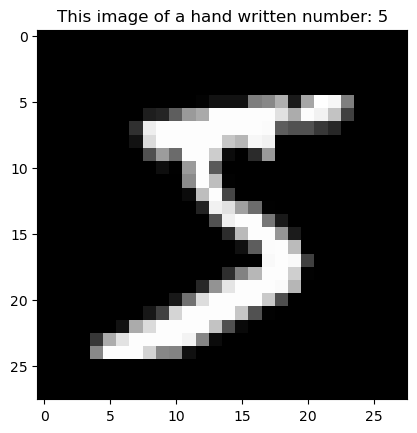

In [2]:
# load data from sklearn
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'] # two dataframes
y_one_hot_array = pd.get_dummies(y, prefix='class').to_numpy().astype(int)
# plot first example
image = X.iloc[0].values.reshape(28, 28)
label = y.iloc[0]
plt.title(f'This image of a hand written number: {label}')
plt.imshow(image, cmap='gray')

# 2. Activation Functions

In [3]:
def ReLU(x):
    # rectified linear unit
    return np.maximum(0, x)

def SELU(x):
    # scaled exponential linear unit
    return np.where(x <= 0, 1.75809 * (np.exp(x)-1), 1.0507 * x)

def tanh(x):
    # hyperbolic tangent
    x = np.clip(x, -500, 500)  # prevent overflow
    exp_x = np.exp(x)
    exp_neg_x = np.exp(-x)
    return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)


def softmax(x):
    denominator = np.sum(np.exp(x)) # sum of all the e^logit for every logit
    return np.exp(x) / denominator # normalize e^logit value by sum of e^logits


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# 3. Initialize Numpy Neural Network
<img src='media/nn_arcitecture.png' alt='Network Arcitecture'>

## Weight Initializations

In [4]:
def xavier_init(size):
    in_dim, out_dim = size
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size)


def he_init(size):
    in_dim, _ = size
    stddev = np.sqrt(2 / in_dim)
    return np.random.normal(0, stddev, size)

In [ ]:
# Declare simple network
import importlib
from linearnn import linearnnclasses
importlib.reload(linearnnclasses)
from linearnn import activationfunctions

importlib.reload(activationfunctions)
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax, DummyActivation
from linearnn.optim import AdamOptimizer

class CategoricalCrossEntropy:
    """
    soft max is incorperated with this to allow computation of softmax gradient SO last layer of model can use DummyActivation (does nothing)

    """
    def __init__(self, l2_lambda=0.0):  # add L2 regularization coefficient
        self.l2_lambda = l2_lambda

    def forward(self, y, y_hat, weights=None):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        softmax_output = np.clip(softmax_output, 1e-15, 1 - 1e-15)

        # cross-entropy 
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(softmax_output)) / batch_size
        
        if not weights is None:
            # L2 regularization term added to loss
            l2_reg = self.l2_lambda * np.sum(weights ** 2)
        else: l2_reg = 0
        return loss + l2_reg

    def derivative(self, y, y_hat):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return (softmax_output - y) / y.shape[0]

learning_rate = 0.07


hiddenlayer01 = linearnnclasses.LinearLayer(
    input_size=784, 
    output_size=2000, 
    activation_fn_class=ReLU, 
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer # a seperate instace for each layer cuz each layer is a different shape
)

hiddenlayer02 = linearnnclasses.LinearLayer(
    input_size=2000, 
    output_size=500, 
    activation_fn_class=SELU, 
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)


hiddenlayer03 = linearnnclasses.LinearLayer(
    input_size=500, 
    output_size=64, 
    activation_fn_class=Tanh, 
    weight_init=xavier_init, # this init is for tanh activation
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)

outputlayer = linearnnclasses.LinearLayer(
    input_size=64, 
    output_size=10, 
    activation_fn_class=DummyActivation, # dummy activation because softmax is incorperated into the loss function
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)


num_epochs = 200
batch_size = 100

split_position = 50_000
X_test = X.iloc[split_position:].values / 255
y_test = y_one_hot_array[split_position:,:]
y_truth = np.argmax(y_test, axis=1) # convert from onehot to just the correct number
split_position = 50_000 # reinitialized to decide training data size

train_losses = []
test_losses = []
test_accuracies = []
epochs = list(range(num_epochs)) # if stopping training prematurely this could be an issue

training_loss_class = CategoricalCrossEntropy(l2_lambda=1e-4)

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    batch_counter = 0 # keep track of number of epochs to get average of training losses
    for i in range(0, X.iloc[0:split_position].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]

        # forwaed pass
        hidden_output = hiddenlayer01.forward(x_batch, backprop=True)
        hidden_output = hiddenlayer02.forward(hidden_output, backprop=True)
        hidden_output = hiddenlayer03.forward(hidden_output, backprop=True)

        y_hat = outputlayer.forward(hidden_output, backprop=True) # do forward pass saving inputs at each step


        # compute loss
        loss = training_loss_class.forward(y=y_batch, y_hat=y_hat, weights=outputlayer.weights)
        running_loss += loss


        # back propagation
        loss_gradient = training_loss_class.derivative(y=y_batch, y_hat=y_hat)

        output_layer_gradient = outputlayer.backward(output_gradient=loss_gradient, y = y_batch) # have to pass y for derivative of soft max

        hidden_layer_gradient = hiddenlayer03.backward(output_gradient=output_layer_gradient)      
        hidden_layer_gradient = hiddenlayer02.backward(output_gradient=hidden_layer_gradient)      
        hidden_layer_gradient = hiddenlayer01.backward(output_gradient=hidden_layer_gradient)      





        batch_counter += 1


    running_loss /= batch_counter # get average of batch losses for the epoch
    train_losses.append(running_loss)

    # predicted_nums = np.argmax(y_hat, axis=1)
    # correct_predictions = np.sum(predicted_nums == y_truth)
    # train_accuracy = correct_predictions / y_truth.shape[0]
    


    # Evaluation on Test set (only done once per epoch)
    hidden_output = hiddenlayer01.forward(X_test, backprop=False) # back prop as false because no need store intermediate values
    hidden_output = hiddenlayer02.forward(hidden_output, backprop=False)
    hidden_output = hiddenlayer03.forward(hidden_output, backprop=False)
    y_hat = outputlayer.forward(hidden_output, backprop=False) # back prop as false because no need store intermediate values
    
    test_loss = CategoricalCrossEntropy(l2_lambda=0.0).forward(y=y_test, y_hat=y_hat)
    test_losses.append(test_loss)

    predicted_nums = np.argmax(y_hat, axis=1)
    correct_predictions = np.sum(predicted_nums == y_truth)
    test_accuracy = correct_predictions / y_truth.shape[0]
    test_accuracies.append(test_accuracy)

    print(f'Epoch: {epoch}, train loss: {running_loss:0.3f}, test loss: {test_loss:0.3f}, train acc: {None}, test acc: {test_accuracy:0.3f}')

In [71]:
layers = [hiddenlayer01, hiddenlayer02, hiddenlayer03, outputlayer]
import joblib
joblib.dump(layers, r'trained_layers_test_at_94acc.pkl')

['trained_layers_test_at_94acc.pkl']

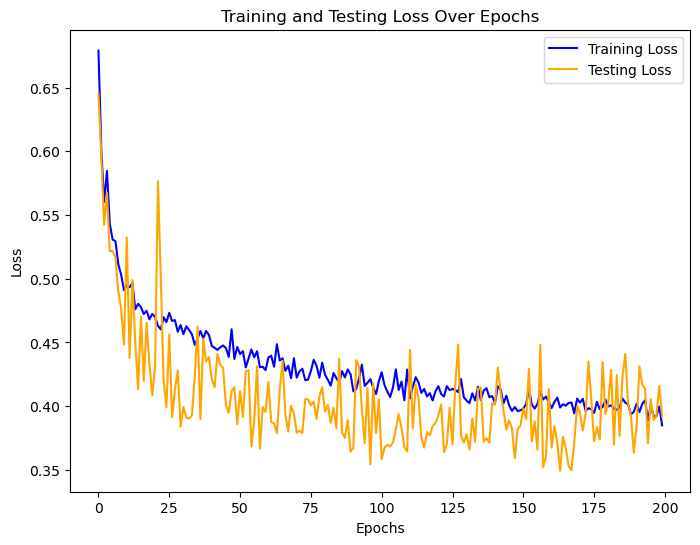

In [72]:
import matplotlib.pyplot as plt

# Assuming train_losses, test_losses, and epochs are already populated
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker=None)

# Plot testing loss
plt.plot(epochs, test_losses, label='Testing Loss', color='orange', marker=None)

# Add title and labels
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [144]:
x_batch = X.iloc[0:100].values / 255
print(x_batch.shape)

(100, 784)


# Using Sequential model class (under developement)

In [23]:
from linearnn import linearnnclasses
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax
# from linearnn.optim import AdamOptimizer
from linearnn import optim
import importlib
importlib.reload(linearnnclasses)
importlib.reload(optim)

class CategoricalCrossEntropy:
    # soft max is incorperated with this
    def forward(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))  # shift for numerical stability
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Cross-entropy loss calculation
        softmax_output = np.clip(softmax_output, 1e-15, 1 - 1e-15)  # avoid log(0)
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(softmax_output)) / batch_size
        return loss
    
    def derivative(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return (softmax_output - y) / y.shape[0]



sequential_model = linearnnclasses.SequentialModel(
    input_size=784,
    output_size=10,
    hidden_layers=(1568, 784), 
    activation_fn_classes=(ReLU, SELU, ReLU, Softmax),
    weight_init=(he_init, he_init, he_init, he_init),
    loss_fn_class = CategoricalCrossEntropy,
    optimizer=None#optim.AdamOptimizer # with default settings (see linearnn/optim.py)
)
sequential_model.forward(x_batch)
sequential_model.backward(x_batch, y_one_hot_array[0:100, :])

building model...
Adding: LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.SELU'>
Adding: LinearLayer input:1568, output:784, activation:<class 'linearnn.activationfunctions.ReLU'>
Adding: LinearLayer input:784, output:10, activation:<class 'linearnn.activationfunctions.Softmax'>
model built


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

# 4. Model Training

In [263]:
num_epochs = 50
batch_size = 100

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    for i in range(0, X.iloc[0:60000].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]
        # print(np.unique(x_batch))
        loss = sequential_model.backward(x_batch, y_batch) # forward pass is incorperated in backward function
        # print(x_batch.shape)
        # print(y_batch.shape)
        print(loss)
        if loss == np.nan: print(1/0)
        # break
        running_loss += loss
    # break

    print(running_loss/(X.shape[0]/batch_size))


7.292762465215206
7.314172449721973
7.129204141841925
7.148207841704977
7.128680245987088
7.152731195564415
7.1472311280660366
7.22489715045167
7.206244743507414
7.09306089941958
7.144879556839974
7.1130051053909815
7.388344643083676
7.077581667837615
7.099552577768813
7.103527880421407
7.116570642259125
7.114268146538884
7.093622193912385
7.219028239463915
7.294398812233866
7.178690199835334
7.109915178218196
7.208174552923054
7.177926353417172
7.195112668629238
7.118757767345551
7.193112470210646
7.1331989563323885
7.163177274217185
7.118299904064668
7.24977598165777
7.1122541974183555
7.1519954911735155
7.128383522933937
7.10583277487387
7.150763298760633
7.110909920838911
7.140160857236701
7.130824779804532
7.105591796925299
7.17516111693398
7.1978415645341265
6.972018397563418
7.056152015349506
7.133973906549702
7.194210586582451
7.2382292439898155
7.151886470916285
6.993398117685756
7.1281455388152475
7.059622908124186
7.056767292819064
7.049793065249981
7.145765957842015
6.93778

KeyboardInterrupt: 

In [203]:
X[-100:-1].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [215]:
preds = sequential_model.forward(X[-100:-1].values)

In [216]:
max_indices = np.argmax(preds, axis=1)
max_indices

array([7, 7, 7, 7, 7, 1, 9, 4, 2, 5, 7, 7, 1, 7, 7, 7, 7, 6, 1, 9, 7, 8,
       7, 7, 6, 7, 7, 2, 6, 7, 6, 9, 2, 1, 6, 9, 7, 1, 7, 7, 1, 5, 8, 8,
       9, 0, 9, 7, 9, 6, 7, 1, 8, 7, 9, 1, 9, 5, 2, 9, 5, 9, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 6, 5, 7, 7, 9, 7, 9, 7, 7, 9, 9, 0, 7, 9, 1, 7,
       7, 7, 7, 8, 7, 7, 7, 2, 1, 1, 1], dtype=int64)

In [217]:
np.argmax(y_one_hot_array[-100:-1, :], axis=1)

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], dtype=int64)